In [103]:
import numpy as np
import scipy.signal as signal
import ftm1d
import IPython.display as ipd
import matplotlib.pyplot as plt
import soundfile as sf

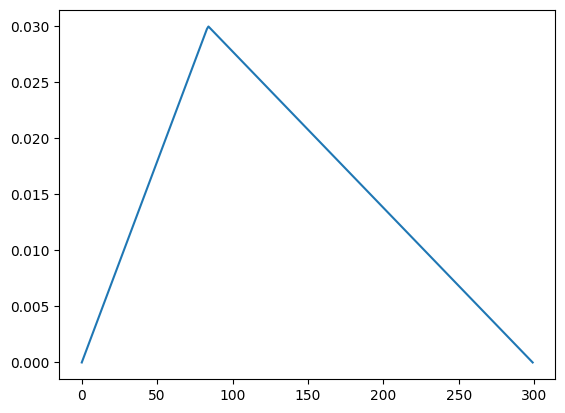

In [186]:
tau=300
l = 1.
h = l/tau
x0= 0.28
pluckdis=0.03

x = np.linspace(0,l,tau)#range and how many points
#print(x)
x = np.minimum(pluckdis/x0*x,-pluckdis/(l-x0)*x+pluckdis*l/(l-x0))
plt.plot(x)
plt.show()

In [223]:
def getf(m,l,tau,x0=0.28,pluckdis=0.03,mode='gaus'): #calculate the f_m which takes spatial component of excitation.
    #trapezoid rule to integrate f(x)sin(mpix) from 0 to l
    #(f(a)+f(b))*(b-a)/2
    integral = 0
    h = l/tau
    if mode == "gaus":
        x = approxnorm(l,l/2,0.4,tau) #f(x)
    elif mode == "tri":
        x = np.arange(0,tau+1,1)*h
        x = np.minimum(2-2/l*x,2*x/l)
    elif mode == "delta":
        x = np.zeros(tau+1)
        x[tau//2] = 1
    elif mode == "shape":
        x = np.linspace(0,l,tau+1)
        x = np.minimum(pluckdis/x0*x,-pluckdis/(l-x0)*x+pluckdis*l/(l-x0))
    elif mode == "random":
        x = np.random.rand(tau+1)

    for i in range(tau):
        #x(i+2)
        #print(x.shape,x[0],x[0,1])
        integral = integral + (x[i] * np.sin(m * np.pi * i * h/l) + x[i+1] * np.sin(m * np.pi * (i + 1) * h/l))*h/2
    integral = integral*2/l
    return integral

In [236]:
fm = []
for m in range(100):
    fm.append(getf(m,1,300,mode='gaus'))
km = fm*np.sin(np.arange(0,100,1)*0.5)
fm1 = []
for m in range(100):
    fm1.append(getf(m,1,300,mode='tri'))
fm2 = []
for m in range(100):
    fm2.append(getf(m,1,300,mode='random'))
fm3 = []
for m in range(100):
    fm3.append(getf(m,1,300,mode='shape'))
       

In [237]:
getf(10,1,300,mode="tri"),getf(10,1,300,mode="random")

(3.9403549189796425e-17, -0.02278218019408202)

In [238]:
fm1[10],fm2[10]

(3.9403549189796425e-17, 0.013624322034760846)

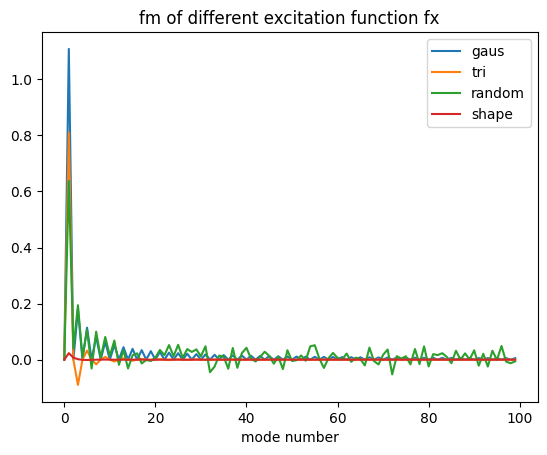

In [245]:
plt.plot(fm,label="gaus")
plt.plot(fm1,label="tri")
plt.plot(fm2,label="random")
plt.plot(fm3,label="shape")
plt.legend()
plt.title("fm of different excitation function fx")
plt.xlabel("mode number")
plt.show()

In [97]:
#difference equation form
def getsounds_dif(m,w11,tau11,p,D,sr,x):
    l = np.pi
    s11 = -1/tau11

    sigma=np.zeros(m)
    omega=np.zeros(m)
    k=np.zeros(m)
    fms = []
    for i in range(m):
        sigma[i] = getsigma(i+1,p,s11)
        omega[i] = getomega(i+1,p, D,w11,s11)
        k[i] = getk(i+1,omega[i],getf(i+1,1,300),x)
        
        fms.append(getf(i+1,1,300))
        
    debug = [k,fms]       
    dur = 2**16
    y_1 = np.zeros((m,))
    y_2 = np.zeros((m,))
    x_1 = 0.0
    x_0 = 1
    y_iii = []
    for n in range(dur):
        
        #each sigma, omega corresponds to a matrix of modes, thus when updating need a matrix of y values
        ytemp = 2*np.exp(sigma/sr)*np.cos(omega/sr)*y_1-np.exp(2*sigma/sr)*y_2+np.exp(sigma/sr)*np.sin(omega/sr)*k*x_1
        #the additional k above was what caused the homogenous decay 
        #ytemp = 2*np.exp(sigma/sr)*np.cos(omega/sr)*y_1-np.exp(2*sigma/sr)*y_2+np.exp(sigma/sr)/omega*np.sin(omega/sr)*x_1 
        #with impulse
        y_iii.append(np.sum(np.sum(ytemp)))
     
        x_1 = x_0
        x_0 = 0.0
        y_2 = y_1
        y_1 = ytemp
            
    return y_iii,debug


In [226]:
getf(2,1,300,"gaus"),getf(2,1,300,"delta")

(6.918565113173125e-18, 6.918565113173125e-18)

In [247]:
#impulse equation form
def getsounds_imp(m,w11,tau11,p,D,sr,x,mode_t="del",mode_x="gaus"):
    l = np.pi
    s11 = -1/tau11

    sigma=np.zeros((m))
    omega=np.zeros((m))
    k=np.zeros((m))
    for i in range(m):
        sigma[i] = getsigma(i+1,p,s11)
        omega[i] = getomega(i+1,p,D,w11,s11)
        k[i] = getk(i+1,omega[i],getf(i+1,1,300,mode=mode_x),x)
        #print(getf(i+1,1,300,mode=mode_x))

    #sr = 44100
    #print(omega,sigma,k)
    dur = 2**16
    #convolve time component of excitation with omega
    excit_dur = 3e-3*sr #3ms of excitation
    d_time = np.arange(0,excit_dur,1) 
    if mode_t == "tri":       
        d_time = 1-d_time/excit_dur #triangular time excitation
    elif mode_t == "del":
        d_time = 0*d_time
        d_time[0] = 1.0
    elif mode_t == "inv":
        param=40
        b = param/excit_dur
        a = param + param**2/excit_dur
        d_time = a/(d_time+param)-b
    elif mode_t == "line":
        d_time = 0*d_time+1
    elif mode_t == "random":
        d_time = np.random.rand(len(d_time))
    

    y = []
    for t in range(dur): #assumed time component of excitation is a delta function.
        y.append(np.sum(np.sum(k * np.exp(sigma * t/sr) * np.sin(omega * t/sr))))
    y = signal.convolve(y,d_time,mode='same') #correct 
    
    return y,k

In [256]:
y2,debugk2 = getsounds_imp(m=100,w11=2000,tau11=0.5,p=0.5,D=1.9,sr=44100,x=0.28,mode_x="gaus")
y3,debugk3 = getsounds_imp(m=100,w11=2000,tau11=0.5,p=0.5,D=1.9,sr=44100,x=0.28,mode_x="tri")
y4,debugk4 = getsounds_imp(m=100,w11=2000,tau11=0.5,p=0.5,D=1.9,sr=44100,x=0.28,mode_x="delta")
y5,debugk5 = getsounds_imp(m=100,w11=2000,tau11=0.5,p=0.5,D=1.9,sr=44100,x=0.28,mode_x="random")
y6,debugk6 = getsounds_imp(m=100,w11=2000,tau11=0.5,p=0.5,D=1.9,sr=44100,x=0.28,mode_x="shape")
display(ipd.Audio(y2,rate=sr))
display(ipd.Audio(y3,rate=sr))
display(ipd.Audio(y4,rate=sr))
display(ipd.Audio(y5,rate=sr))
display(ipd.Audio(y6,rate=sr))
#sf.write("ivan_gausspace.wav",y2/max(y2),sr)
#sf.write("ivan_trispace.wav",y3/max(y3),sr)
#sf.write("ivan_deltaspace.wav",y4/max(y4),sr)
#sf.write("ivan_randomspace.wav",y5/max(y5),sr)
#sf.write("ivan_shapespace.wav",y6/max(y6),sr)


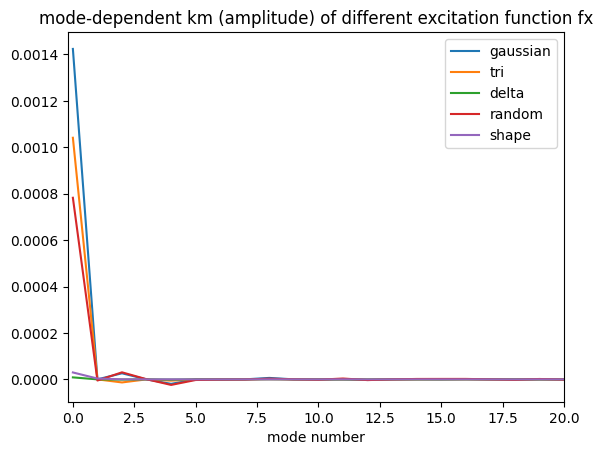

In [255]:
plt.plot(debugk2,label="gaussian")
plt.plot(debugk3,label="tri")
plt.plot(debugk4,label="delta")
plt.plot(debugk5,label="random")
plt.plot(debugk6,label="shape")
plt.legend()
plt.title('mode-dependent km (amplitude) of different excitation function fx')
plt.xlabel("mode number")
plt.xlim([-0.2,20])
plt.show()

In [105]:
y,debugk = getsounds_dif(m=10,w11=2000,tau11=0.5,p=0.5,D=0.9,sr=44100,x=0.28)
y2,debugk2 = getsounds_imp(m=10,w11=2000,tau11=0.5,p=0.5,D=0.9,sr=44100,x=0.28) #f in space has to be a delta?
sr = 44100
display(ipd.Audio(y,rate=sr))
display(ipd.Audio(y2,rate=sr))
sf.write("ivan_gausspace.wav",y/max(y),sr)
sf.write("ivan_deltaspace.wav",y2/max(y2),sr)

In [75]:
debug_k,debug_f = debugk

In [92]:
debugk2

array([ 2.56837748e-06,  2.16511538e-22, -5.87155295e-07,  8.28803355e-23,
       -7.01204388e-07, -1.90861333e-22,  6.61557222e-08, -1.54962286e-22,
        4.10117188e-07,  1.33145660e-22])

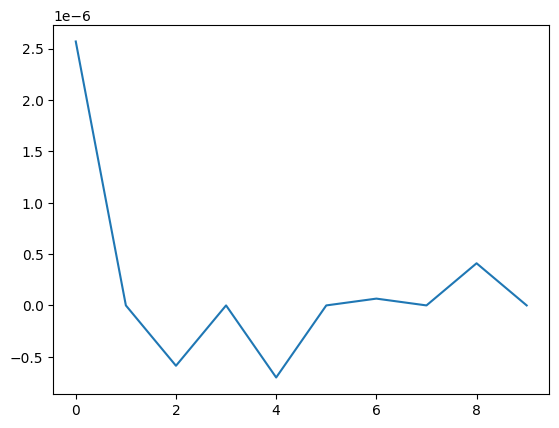

In [94]:
#plt.plot(debug_k)
plt.plot(debugk2)
plt.show()

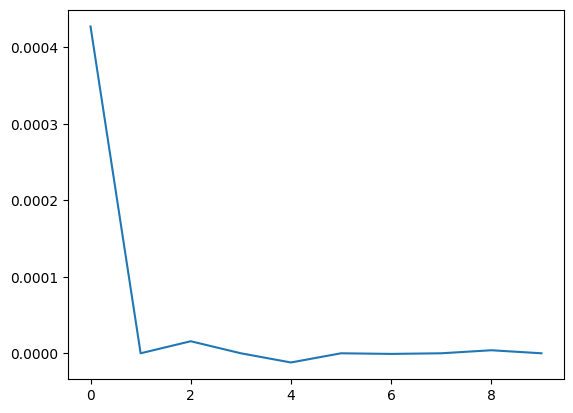

In [84]:
plt.plot(debug_k)
#plt.plot(debug_f)
plt.show()

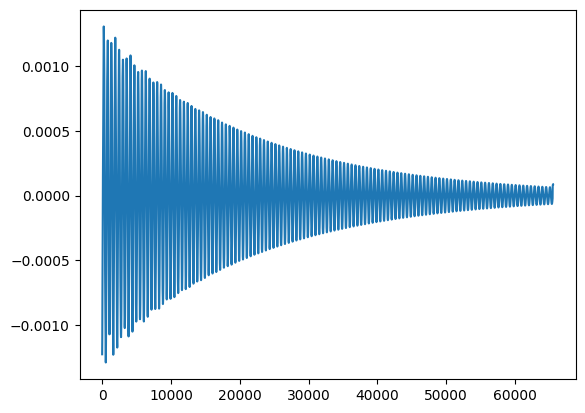

In [41]:
plt.plot(y-y2)
plt.show()

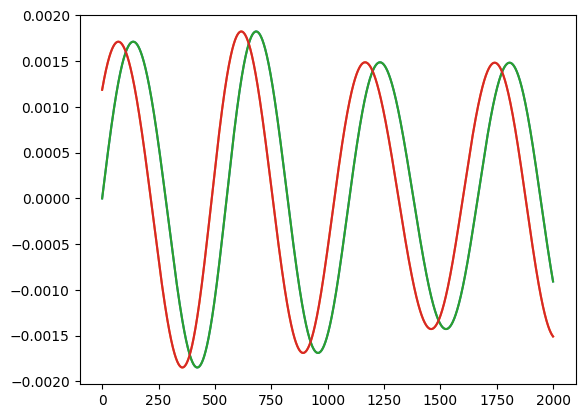

In [35]:
plt.plot(y[:2000])
plt.plot(y2[:2000])
plt.show()

In [106]:
np.log(44100)/np.log(2)

15.428491035332245

In [110]:
import librosa
y,sr = librosa.load("/Users/lilyh/Downloads/flute_playingtechniques.mp3",44100)
sf.write("/Users/lilyh/Downloads/flute_playingtechniques.wav",y,sr)

/Users/lilyh/anaconda3/envs/openl3/lib/python3.7/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")


In [109]:
sr

22050